In [1]:
import csv
from sympy import isprime

def generate_twin_primes(limit, filename="twin_primes.csv"):
    """
    Generates all twin prime pairs up to the given limit
    and writes them to a CSV file.
    """
    twin_primes = []

    for n in range(3, limit - 1, 2):  # Only check odd numbers
        if isprime(n) and isprime(n + 2):
            twin_primes.append((n, n + 2))

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["p", "p+2"])
        writer.writerows(twin_primes)

    print(f"✅ {len(twin_primes)} twin primes written to {filename}")


In [2]:
generate_twin_primes(100000, "twins_up_to_100k.csv")


✅ 1224 twin primes written to twins_up_to_100k.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def bin_twin_primes(filename="twins_up_to_100k.csv", bin_size=1000):
    """
    Bins twin prime pairs by the start value p and plots frequency per bin.
    """
    # Load CSV
    df = pd.read_csv(filename)

    # Create a new column for bin index
    df['bin'] = (df['p'] // bin_size) * bin_size

    # Count frequency in each bin
    counts = df['bin'].value_counts().sort_index()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(counts.index, counts.values, width=bin_size*0.8, align='center')
    plt.xlabel(f'Starting value of bin (size={bin_size})')
    plt.ylabel('Number of twin primes')
    plt.title(f'Twin Prime Frequencies per {bin_size}-sized Bin')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return counts


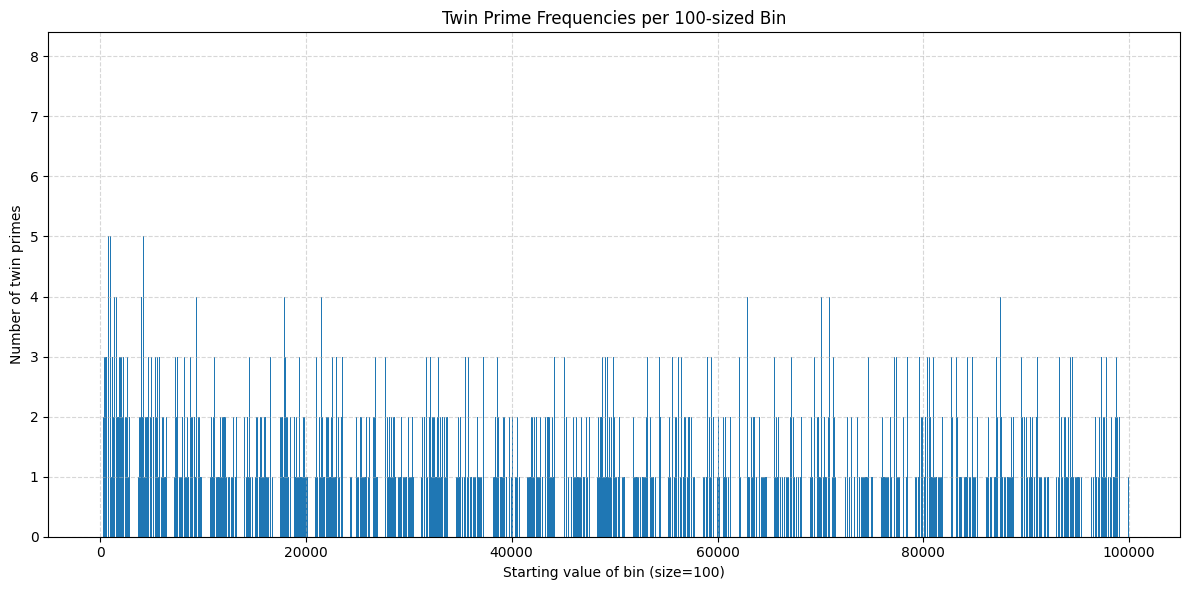

In [4]:
frequencies = bin_twin_primes("twins_up_to_100k.csv", bin_size=100)


In [5]:
def compute_entropy_of_frequencies(freq_series, window_size=10):
    """
    Compute entropy over raw frequency counts in a moving window.
    """
    freqs = freq_series.values
    entropy_values = []

    for i in range(len(freqs) - window_size + 1):
        window = freqs[i:i + window_size]
        probs = window / window.sum() if window.sum() > 0 else np.ones(len(window)) / len(window)
        ent = entropy(probs, base=2)
        entropy_values.append(ent)

    return entropy_values


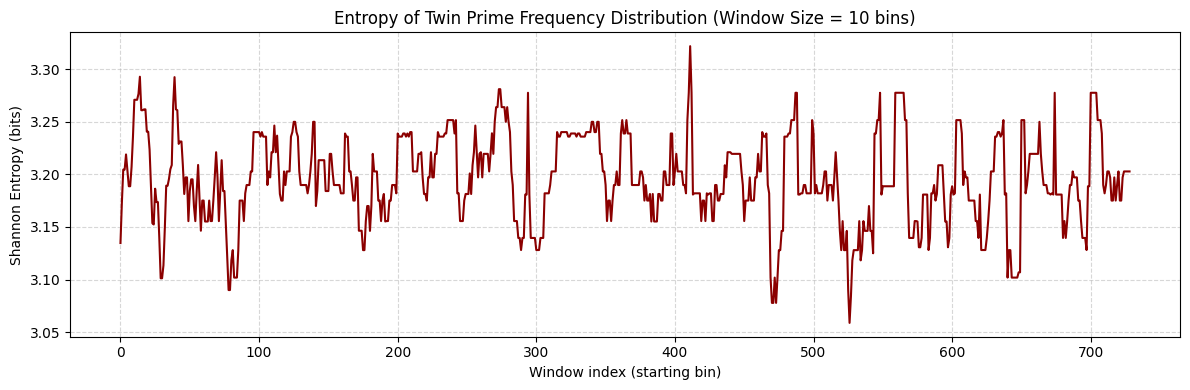

In [6]:
from scipy.stats import entropy

entropy_vals = compute_entropy_of_frequencies(frequencies, window_size=10)

plt.figure(figsize=(12, 4))
plt.plot(entropy_vals, color='darkred')
plt.xlabel("Window index (starting bin)")
plt.ylabel("Shannon Entropy (bits)")
plt.title("Entropy of Twin Prime Frequency Distribution (Window Size = 10 bins)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [7]:
def multiscale_entropy(freq_series, window_sizes):
    """
    Compute entropy over multiple window sizes.

    Parameters:
        freq_series (pd.Series): Indexed by bin starts, values = twin prime counts
        window_sizes (list): List of window sizes (ints)

    Returns:
        dict: keys = window sizes, values = list of entropy values
    """
    results = {}

    for w in window_sizes:
        entropy_vals = []
        freqs = freq_series.values

        for i in range(len(freqs) - w + 1):
            window = freqs[i:i + w]
            if window.sum() == 0:
                probs = np.ones(len(window)) / len(window)  # uniform dummy
            else:
                probs = window / window.sum()
            ent = entropy(probs, base=2)
            entropy_vals.append(ent)

        results[w] = entropy_vals

    return results


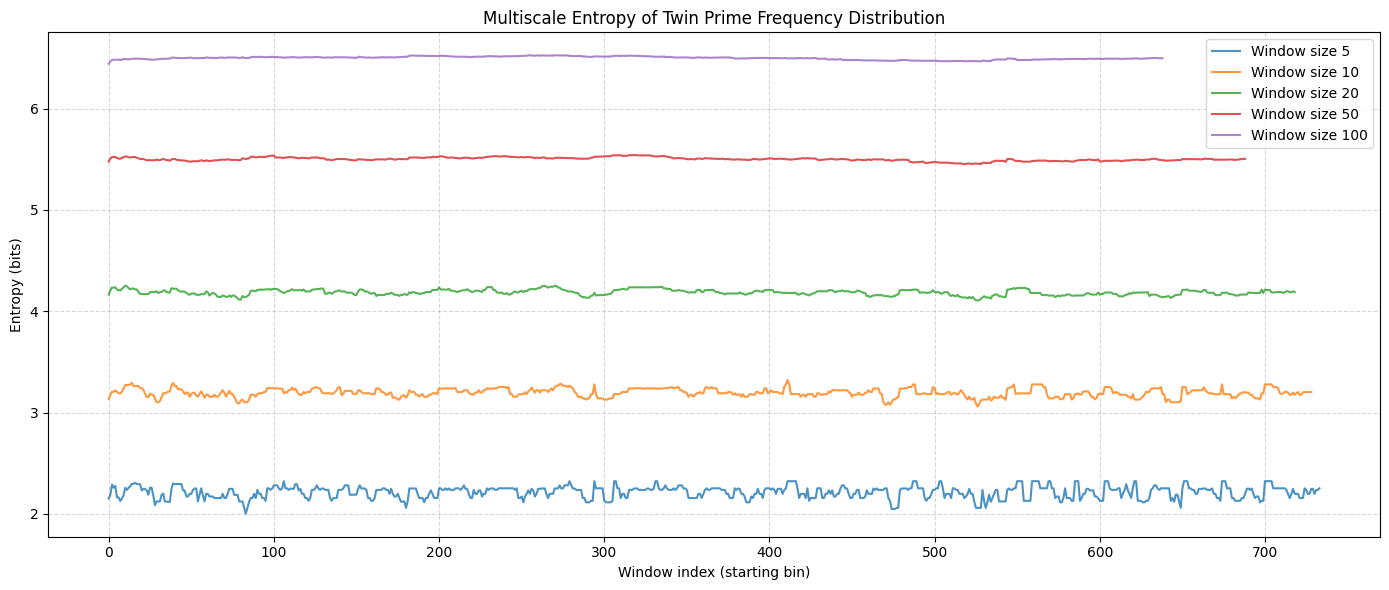

In [8]:
window_sizes = [5, 10, 20, 50, 100]
entropy_dict = multiscale_entropy(frequencies, window_sizes)

plt.figure(figsize=(14, 6))
for w in window_sizes:
    plt.plot(entropy_dict[w], label=f"Window size {w}", alpha=0.8)
plt.xlabel("Window index (starting bin)")
plt.ylabel("Entropy (bits)")
plt.title("Multiscale Entropy of Twin Prime Frequency Distribution")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
def average_entropy_by_scale(entropy_dict):
    """
    Given a dict of window size -> entropy values, compute average entropy per scale.
    """
    return {w: np.mean(entropy_dict[w]) for w in entropy_dict}


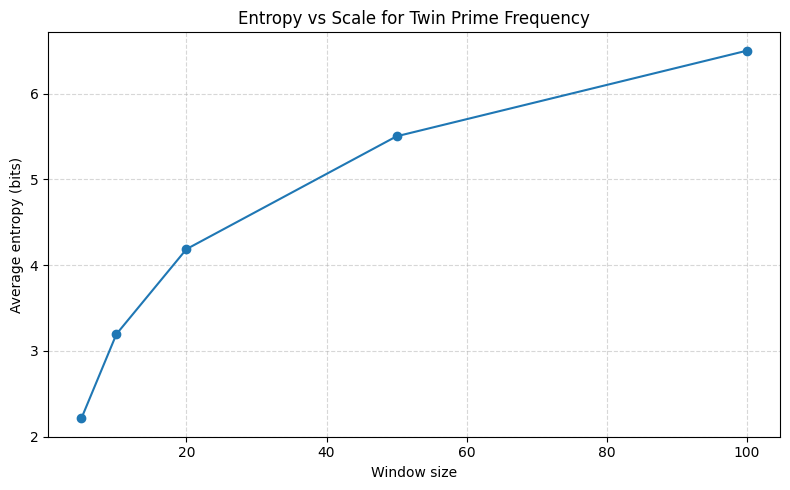

In [10]:
import numpy as np


avg_entropies = average_entropy_by_scale(entropy_dict)

plt.figure(figsize=(8, 5))
plt.plot(list(avg_entropies.keys()), list(avg_entropies.values()), marker='o')
plt.xlabel("Window size")
plt.ylabel("Average entropy (bits)")
plt.title("Entropy vs Scale for Twin Prime Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

def compute_twin_prime_gaps(filename="twins_up_to_100k.csv"):
    """
    Load twin prime pairs and return list of gaps between consecutive starting values.
    """
    df = pd.read_csv(filename)
    p_values = df['p'].values
    gaps = np.diff(p_values)
    return gaps


In [12]:
def gap_entropy(gaps, num_bins=10):
    """
    Bins the twin prime gaps and computes the entropy of the gap distribution.

    Returns:
        bin_edges, counts, entropy_value
    """
    counts, bin_edges = np.histogram(gaps, bins=num_bins)
    probs = counts / counts.sum()
    ent = entropy(probs, base=2)

    return bin_edges, counts, ent


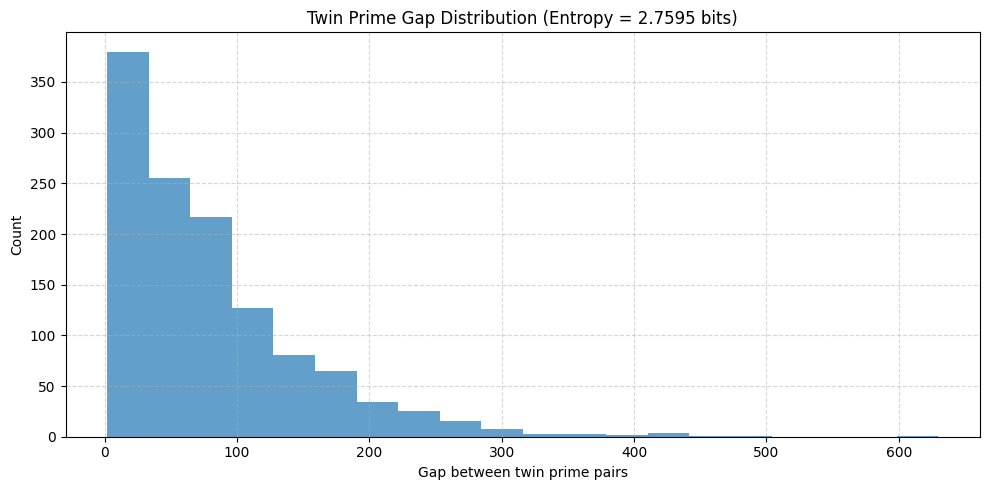

In [13]:
gaps = compute_twin_prime_gaps("twins_up_to_100k.csv")
bins, counts, ent = gap_entropy(gaps, num_bins=20)

plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], counts, width=np.diff(bins), align='edge', alpha=0.7)
plt.xlabel("Gap between twin prime pairs")
plt.ylabel("Count")
plt.title(f"Twin Prime Gap Distribution (Entropy = {ent:.4f} bits)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
def sliding_gap_entropy(gaps, window_size=20, num_bins=10):
    """
    Compute entropy of twin prime gap distributions in a sliding window.

    Parameters:
        gaps (np.array): array of gap values
        window_size (int): number of consecutive gaps per window
        num_bins (int): number of bins to discretize the gaps

    Returns:
        List of entropy values
    """
    entropy_values = []

    for i in range(len(gaps) - window_size + 1):
        window = gaps[i:i + window_size]
        counts, _ = np.histogram(window, bins=num_bins)
        probs = counts / counts.sum()
        ent = entropy(probs, base=2)
        entropy_values.append(ent)

    return entropy_values


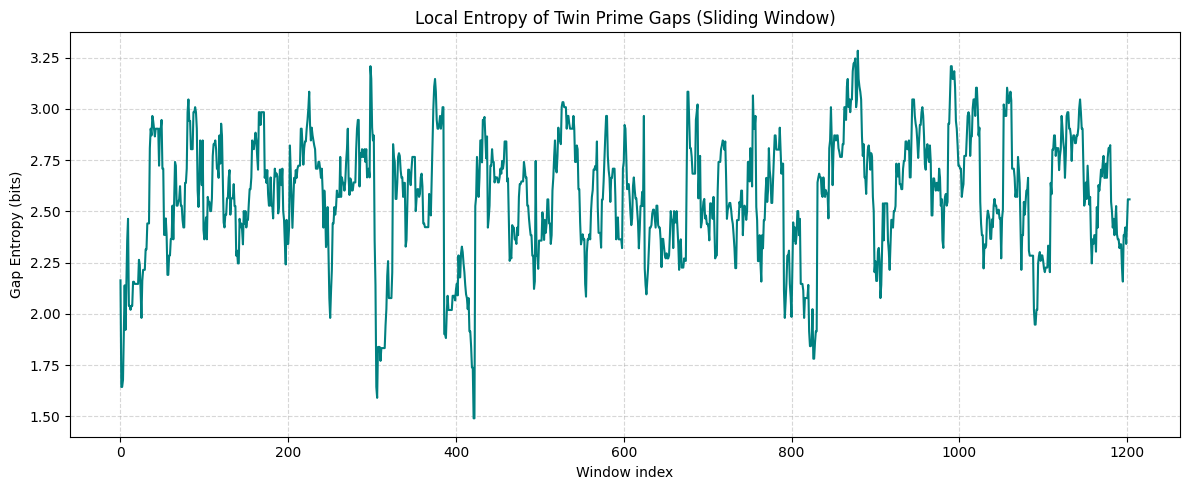

In [15]:
gaps = compute_twin_prime_gaps("twins_up_to_100k.csv")
entropy_vals = sliding_gap_entropy(gaps, window_size=20, num_bins=10)

plt.figure(figsize=(12, 5))
plt.plot(entropy_vals, color='teal')
plt.xlabel("Window index")
plt.ylabel("Gap Entropy (bits)")
plt.title("Local Entropy of Twin Prime Gaps (Sliding Window)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [16]:
def compare_to_shuffled_entropy(gaps, window_size=20, num_bins=10, seed=42):
    """
    Compare entropy trace of real gaps to a shuffled version.
    """
    np.random.seed(seed)
    shuffled = np.copy(gaps)
    np.random.shuffle(shuffled)

    real_entropy = sliding_gap_entropy(gaps, window_size, num_bins)
    shuffled_entropy = sliding_gap_entropy(shuffled, window_size, num_bins)

    plt.figure(figsize=(12, 5))
    plt.plot(real_entropy, label='Real Gap Entropy', color='teal')
    plt.plot(shuffled_entropy, label='Shuffled Gap Entropy', color='orange', alpha=0.6)
    plt.xlabel("Window index")
    plt.ylabel("Entropy (bits)")
    plt.title("Twin Prime Gap Entropy vs. Shuffled Control")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return real_entropy, shuffled_entropy


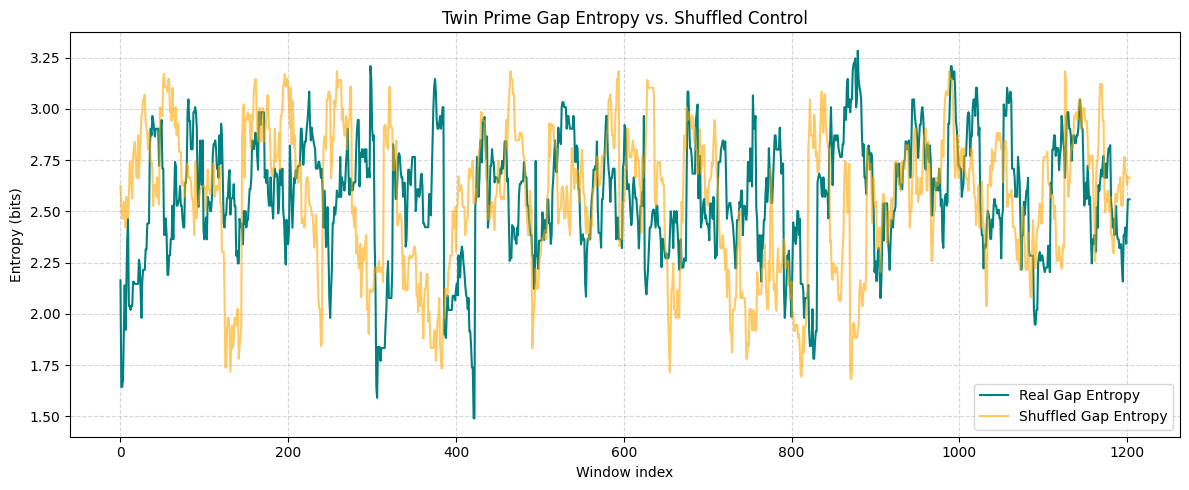

In [17]:
real_e, shuffled_e = compare_to_shuffled_entropy(gaps, window_size=20, num_bins=10)


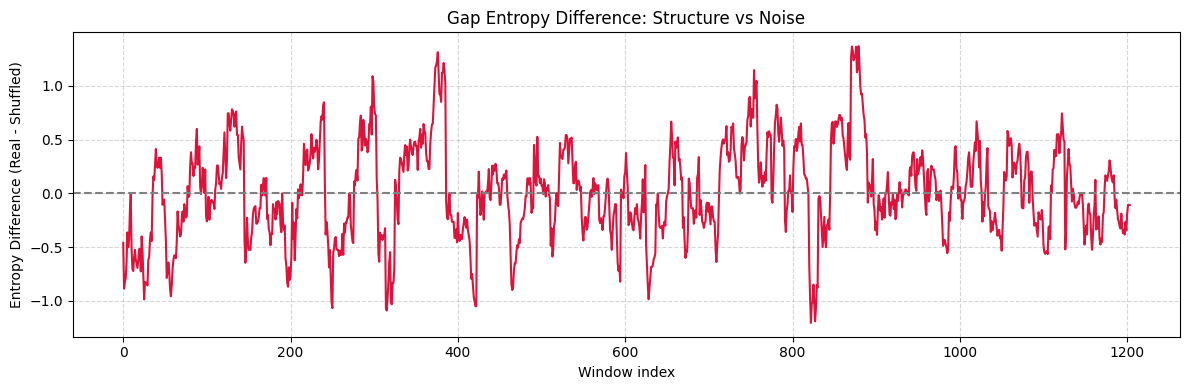

In [18]:
diff = np.array(real_e) - np.array(shuffled_e)

plt.figure(figsize=(12, 4))
plt.plot(diff, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Window index")
plt.ylabel("Entropy Difference (Real - Shuffled)")
plt.title("Gap Entropy Difference: Structure vs Noise")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


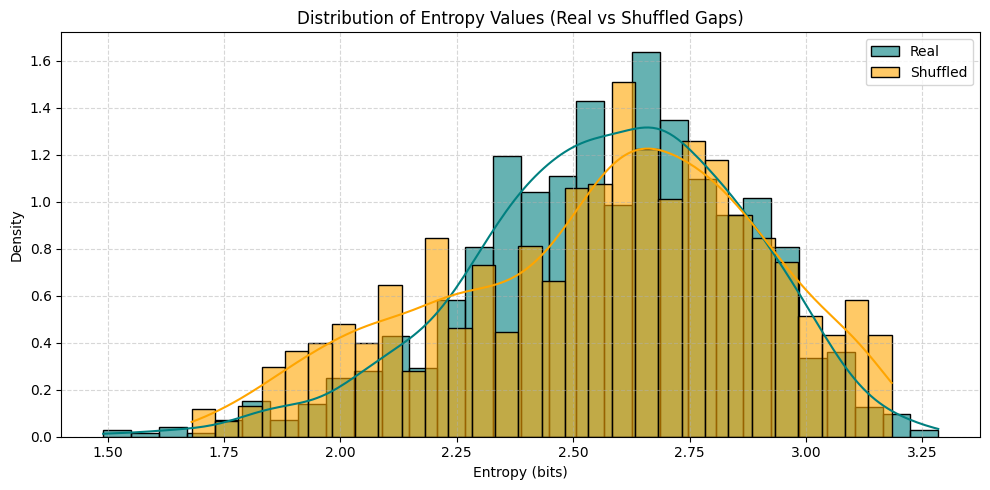

Kolmogorov–Smirnov test: stat=0.0814, p-value=0.0006829
T-test: stat=0.9135, p-value=0.3611


In [19]:
import seaborn as sns
from scipy.stats import ks_2samp, ttest_ind

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(real_e, kde=True, color='teal', label='Real', bins=30, stat="density", alpha=0.6)
sns.histplot(shuffled_e, kde=True, color='orange', label='Shuffled', bins=30, stat="density", alpha=0.6)
plt.title("Distribution of Entropy Values (Real vs Shuffled Gaps)")
plt.xlabel("Entropy (bits)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Stats
ks_stat, ks_p = ks_2samp(real_e, shuffled_e)
tt_stat, tt_p = ttest_ind(real_e, shuffled_e)

print(f"Kolmogorov–Smirnov test: stat={ks_stat:.4f}, p-value={ks_p:.4g}")
print(f"T-test: stat={tt_stat:.4f}, p-value={tt_p:.4g}")


In [20]:
def autocorrelation(signal, max_lag=100):
    """
    Compute autocorrelation of a 1D signal up to a given lag.
    """
    signal = np.array(signal)
    signal -= np.mean(signal)
    signal /= np.std(signal)

    result = np.correlate(signal, signal, mode='full')
    mid = len(result) // 2
    acf = result[mid:mid + max_lag] / result[mid]  # Normalize

    return acf


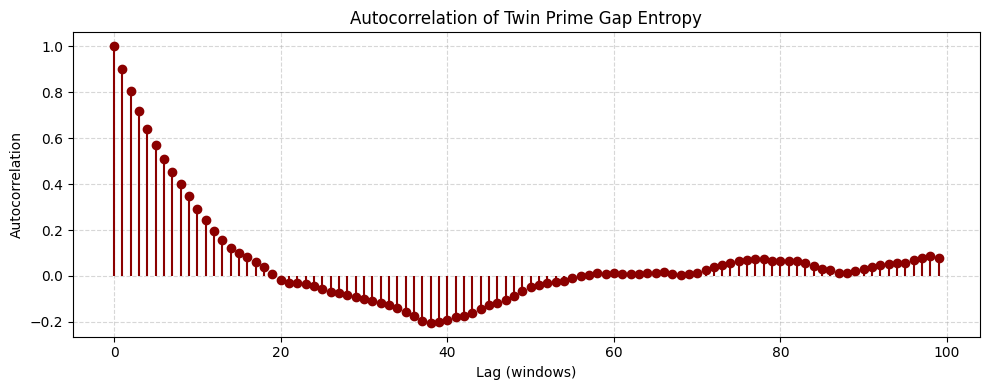

In [21]:
acf = autocorrelation(real_e, max_lag=100)

plt.figure(figsize=(10, 4))
for lag, val in enumerate(acf):
    plt.vlines(lag, 0, val, color='darkred')
    plt.plot(lag, val, 'o', color='darkred')

plt.title("Autocorrelation of Twin Prime Gap Entropy")
plt.xlabel("Lag (windows)")
plt.ylabel("Autocorrelation")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [22]:
from scipy.fft import fft, fftfreq

def plot_entropy_fft(acf, sampling_rate=1):
    """
    Plot the FFT power spectrum of the entropy autocorrelation signal.
    """
    N = len(acf)
    yf = fft(acf)
    xf = fftfreq(N, d=sampling_rate)[:N//2]
    power = np.abs(yf[:N//2])**2

    plt.figure(figsize=(10, 5))
    plt.plot(xf, power, color='indigo')
    plt.title("FFT Power Spectrum of Gap Entropy Autocorrelation")
    plt.xlabel("Frequency (cycles per window)")
    plt.ylabel("Power")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


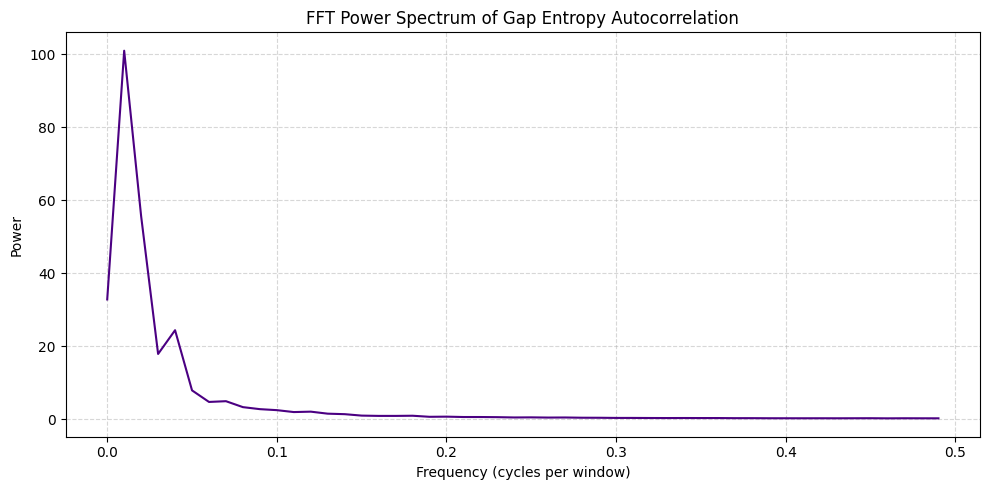

In [23]:
plot_entropy_fft(acf)


In [24]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def wavelet_entropy_transform(signal, wavelet='cmor', scales=np.arange(1, 100)):
    """
    Compute and plot continuous wavelet transform of a 1D entropy signal.
    """
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

    plt.figure(figsize=(12, 6))
    plt.imshow(np.abs(coefficients), extent=[0, len(signal), scales[-1], scales[0]],
               cmap='plasma', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.xlabel("Window Index")
    plt.ylabel("Scale (inverse frequency)")
    plt.title("Wavelet Transform of Twin Prime Gap Entropy")
    plt.tight_layout()
    plt.show()

    return coefficients, frequencies


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


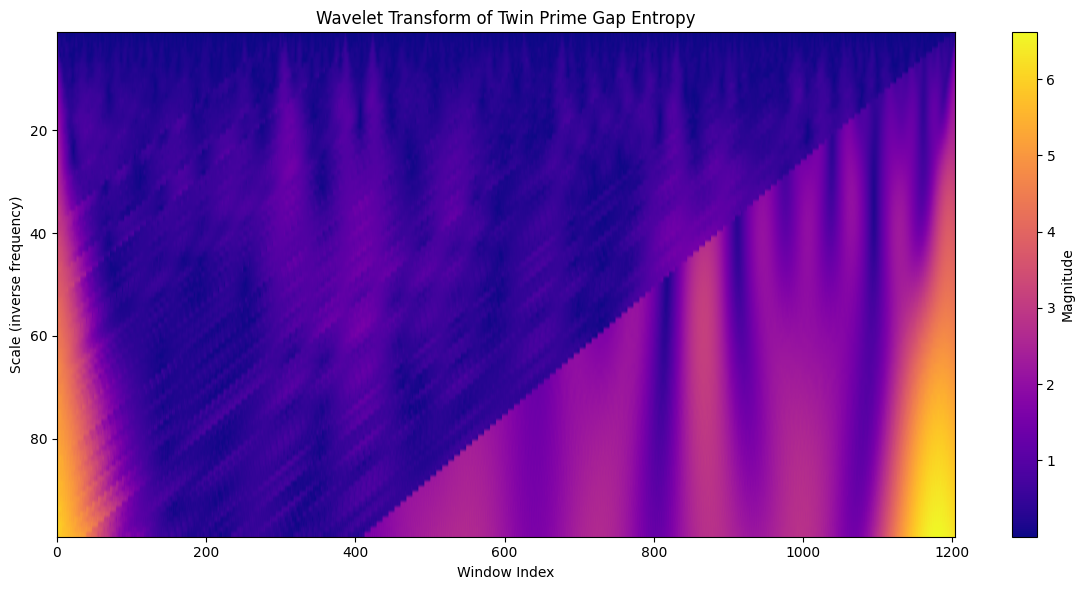

In [25]:
coeffs, freqs = wavelet_entropy_transform(real_e)


In [26]:
def detect_wavelet_ridge(coefficients, scales):
    """
    Detect the scale with max power (ridge) at each time index.
    """
    power = np.abs(coefficients)
    ridge_indices = np.argmax(power, axis=0)  # max over scales
    ridge_scales = scales[ridge_indices]

    return ridge_scales


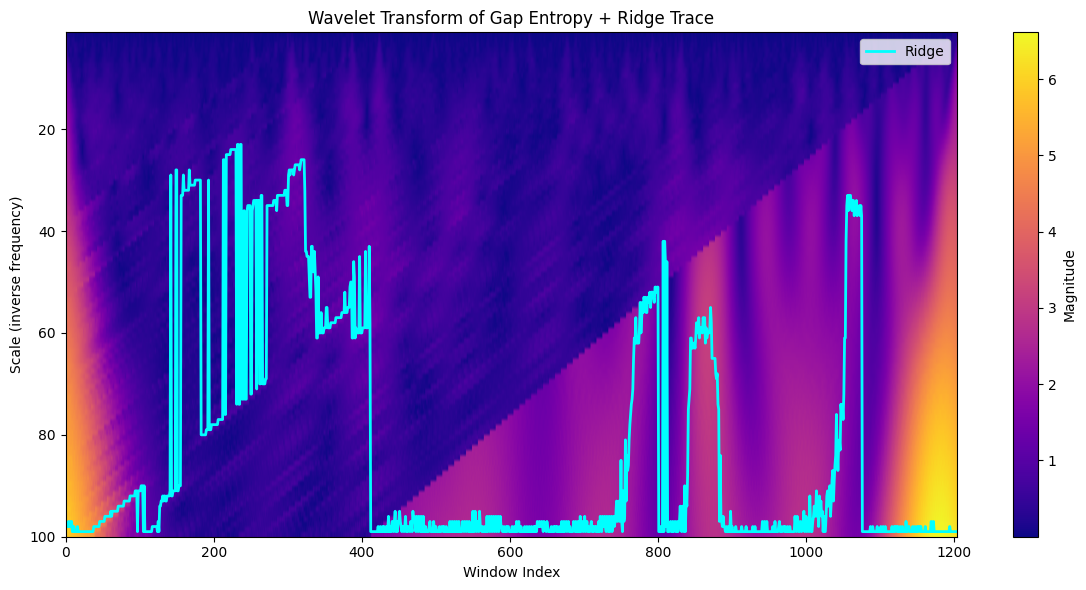

In [27]:
ridge = detect_wavelet_ridge(coeffs, scales=np.arange(1, 100))

plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coeffs), extent=[0, len(ridge), 100, 1],
           cmap='plasma', aspect='auto')
plt.plot(ridge, color='cyan', linewidth=2, label='Ridge')
plt.colorbar(label='Magnitude')
plt.xlabel("Window Index")
plt.ylabel("Scale (inverse frequency)")
plt.title("Wavelet Transform of Gap Entropy + Ridge Trace")
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def delay_embed(signal, tau=5, m=3):
    """
    Constructs a delay embedding of the signal.
    """
    N = len(signal)
    embedded = np.array([
        signal[i:N - (m - 1) * tau + i:tau] for i in range(m)
    ]).T
    return embedded


Explained variance ratio:
  PC1: 0.9313
  PC2: 0.0439

PCA Component Loadings:

PC1:
  r(t + 0): 0.5689
  r(t + 5): 0.5699
  r(t + 10): 0.5929

PC2:
  r(t + 0): 0.7560
  r(t + 5): -0.0786
  r(t + 10): -0.6498


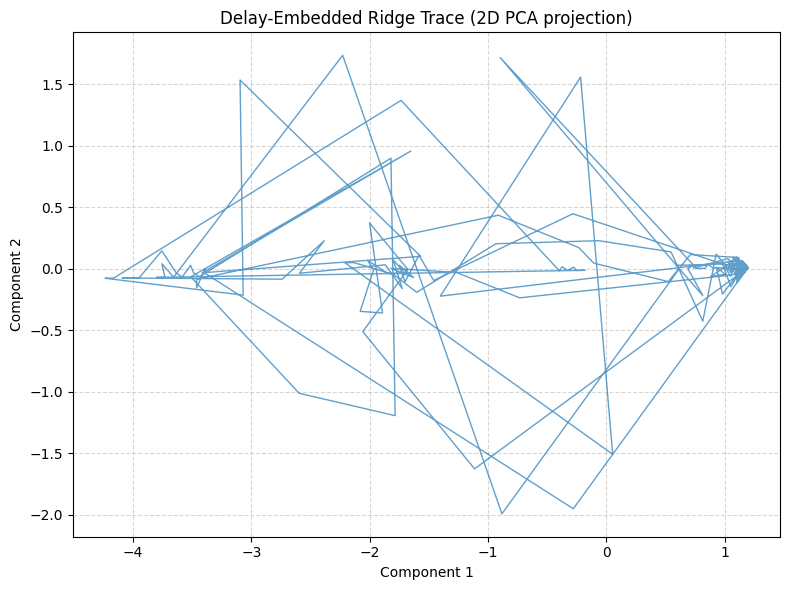

In [29]:
ridge_scaled = StandardScaler().fit_transform(ridge.reshape(-1, 1)).flatten()
embedded = delay_embed(ridge_scaled, tau=5, m=3)

pca = PCA(n_components=2)
projected = pca.fit_transform(embedded)

delay_labels = [f"r(t + {i * 5})" for i in range(3)]

print("Explained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f}")

print("\nPCA Component Loadings:")
for i, comp in enumerate(pca.components_):
    print(f"\nPC{i+1}:")
    for weight, label in zip(comp, delay_labels):
        print(f"  {label}: {weight:.4f}")


plt.figure(figsize=(8, 6))
plt.plot(projected[:, 0], projected[:, 1], alpha=0.7, linewidth=1)
plt.title("Delay-Embedded Ridge Trace (2D PCA projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


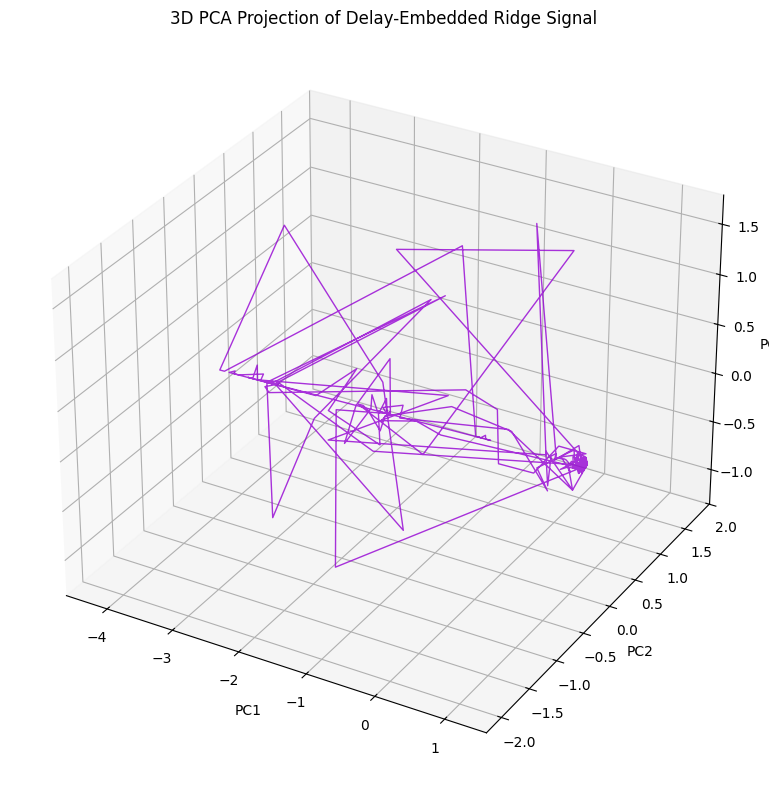

In [30]:
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

pca3d = PCA(n_components=3)
proj3d = pca3d.fit_transform(embedded)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(proj3d[:, 0], proj3d[:, 1], proj3d[:, 2], lw=1, alpha=0.8, color='darkviolet')

ax.set_title("3D PCA Projection of Delay-Embedded Ridge Signal")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()


In [39]:
from ripser import ripser

# Assuming you have your delay-embedded data already in `embedded`
tda_result = ripser(embedded)


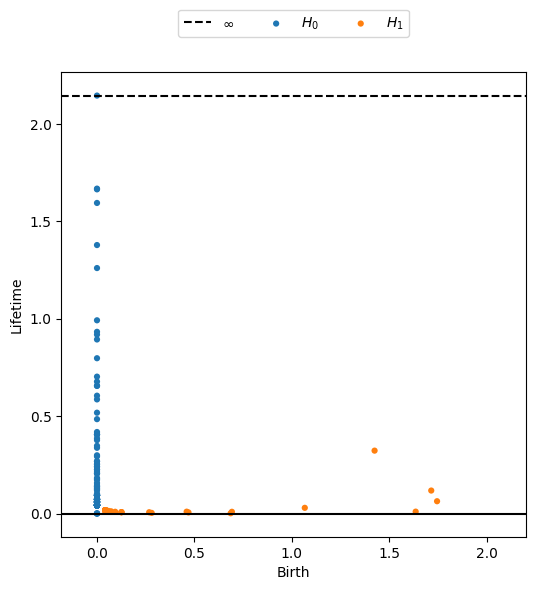

In [40]:
from ripser import ripser
from persim import plot_diagrams

fig = plt.figure(figsize=(6, 6))
plot_diagrams(tda_result['dgms'], show=False, lifetime=True)

# Move legend to the top center
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.tight_layout()
plt.show()



In [41]:
def extract_barcode_lengths(diagrams, dimension=1):
    """
    Extract lifetimes of persistent features in a given homology dimension.
    """
    dgms = diagrams[dimension]
    lifetimes = dgms[:, 1] - dgms[:, 0]
    return lifetimes


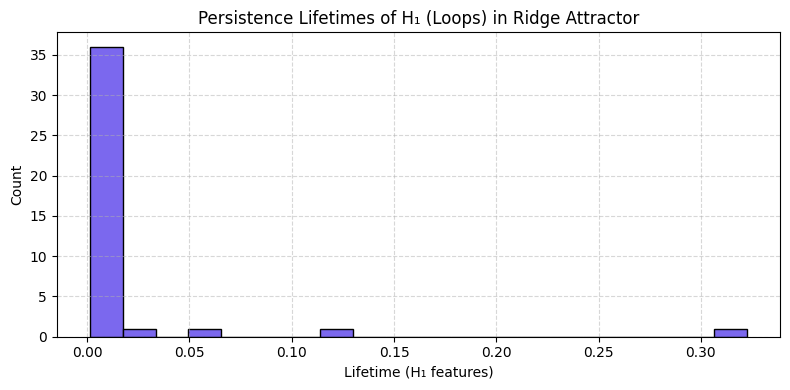

In [42]:
h1_lifetimes = extract_barcode_lengths(tda_result['dgms'], dimension=1)

plt.figure(figsize=(8, 4))
plt.hist(h1_lifetimes, bins=20, color='mediumslateblue', edgecolor='black')
plt.xlabel("Lifetime (H₁ features)")
plt.ylabel("Count")
plt.title("Persistence Lifetimes of H₁ (Loops) in Ridge Attractor")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [43]:
significant = h1_lifetimes[h1_lifetimes > 0.1]
print("Significant H₁ loops (lifetime > 0.1):", significant)


Significant H₁ loops (lifetime > 0.1): [0.11779487 0.32258201]


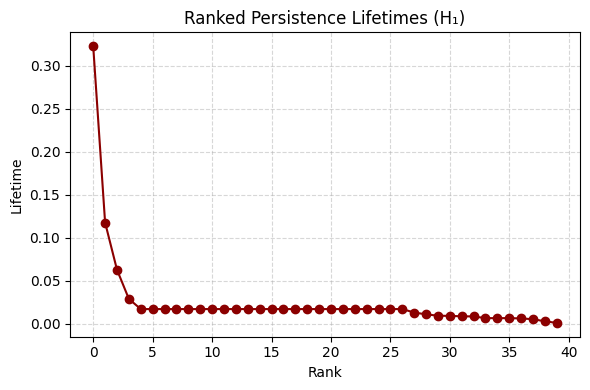

In [44]:
plt.figure(figsize=(6, 4))
plt.plot(np.sort(h1_lifetimes)[::-1], 'o-', color='darkred')
plt.title("Ranked Persistence Lifetimes (H₁)")
plt.xlabel("Rank")
plt.ylabel("Lifetime")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [45]:
entropy_scaled = StandardScaler().fit_transform(np.array(real_e).reshape(-1, 1)).flatten()
embedded_entropy = delay_embed(entropy_scaled, tau=5, m=3)


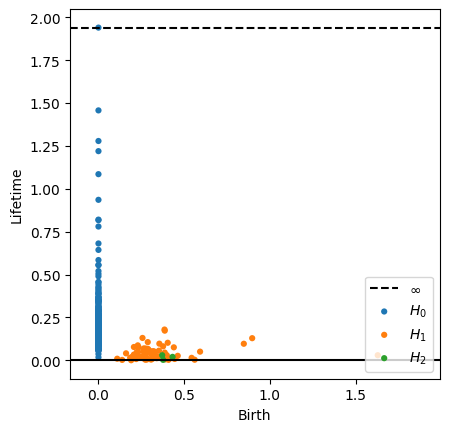

In [46]:
from ripser import ripser
from persim import plot_diagrams

tda_entropy = ripser(embedded_entropy, maxdim=2)
plot_diagrams(tda_entropy['dgms'], show=True, lifetime=True)


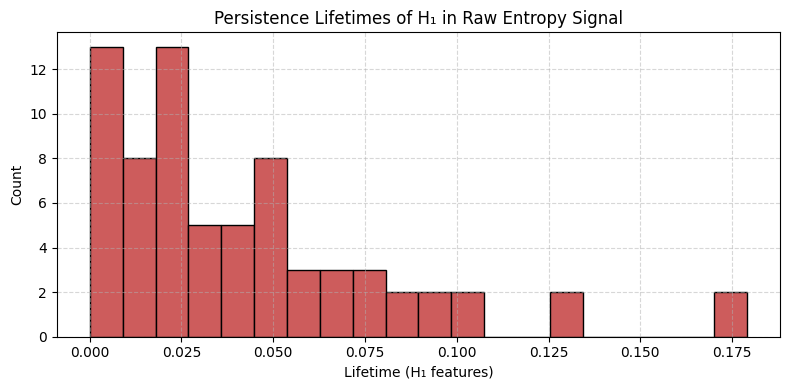

In [47]:
entropy_lifetimes = extract_barcode_lengths(tda_entropy['dgms'], dimension=1)

plt.figure(figsize=(8, 4))
plt.hist(entropy_lifetimes, bins=20, color='indianred', edgecolor='black')
plt.xlabel("Lifetime (H₁ features)")
plt.ylabel("Count")
plt.title("Persistence Lifetimes of H₁ in Raw Entropy Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


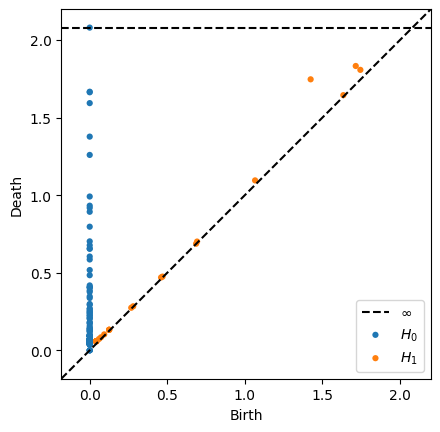

In [48]:
from ripser import ripser
from persim import plot_diagrams

result = ripser(embedded, maxdim=1, coeff=2, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']

plot_diagrams(diagrams, show=True)


In [49]:
h1 = diagrams[1]
lifetimes = h1[:, 1] - h1[:, 0]
top_index = lifetimes.argmax()
top_cocycle = cocycles[1][top_index]  # list of (i, j, coeff)


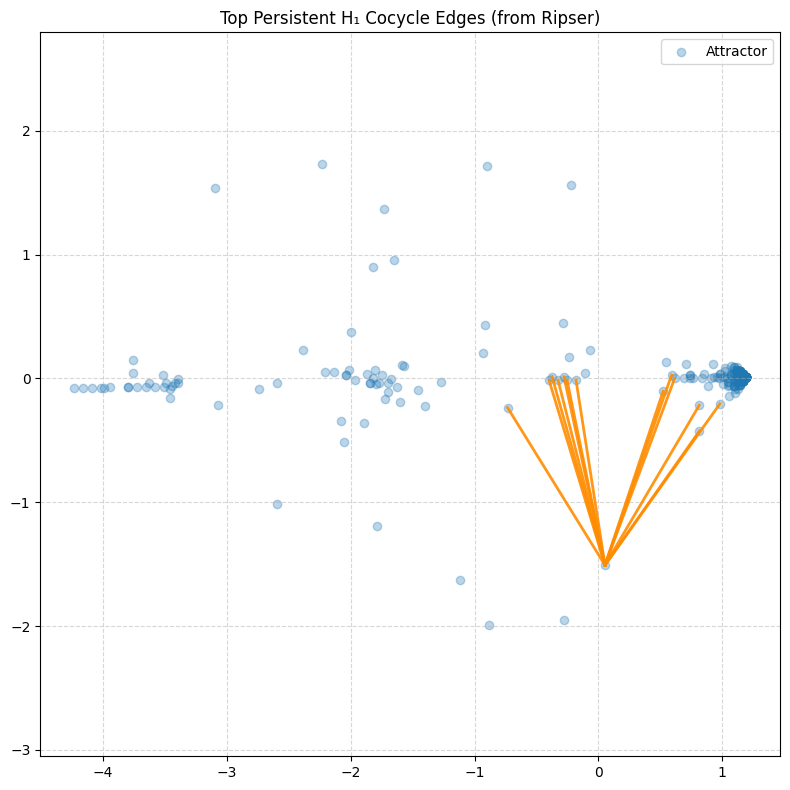

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
projected = pca.fit_transform(embedded)

# Sort edges by magnitude (coeff value)
sorted_edges = sorted(top_cocycle, key=lambda x: abs(x[2]), reverse=True)

plt.figure(figsize=(8, 8))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.3, label="Attractor")

# Plot top N edges
for i, (a, b, coeff) in enumerate(sorted_edges[:30]):  # ← try top 10 edges
    x = [projected[a, 0], projected[b, 0]]
    y = [projected[a, 1], projected[b, 1]]
    plt.plot(x, y, color='darkorange', linewidth=2, alpha=0.9)

plt.title("Top Persistent H₁ Cocycle Edges (from Ripser)")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


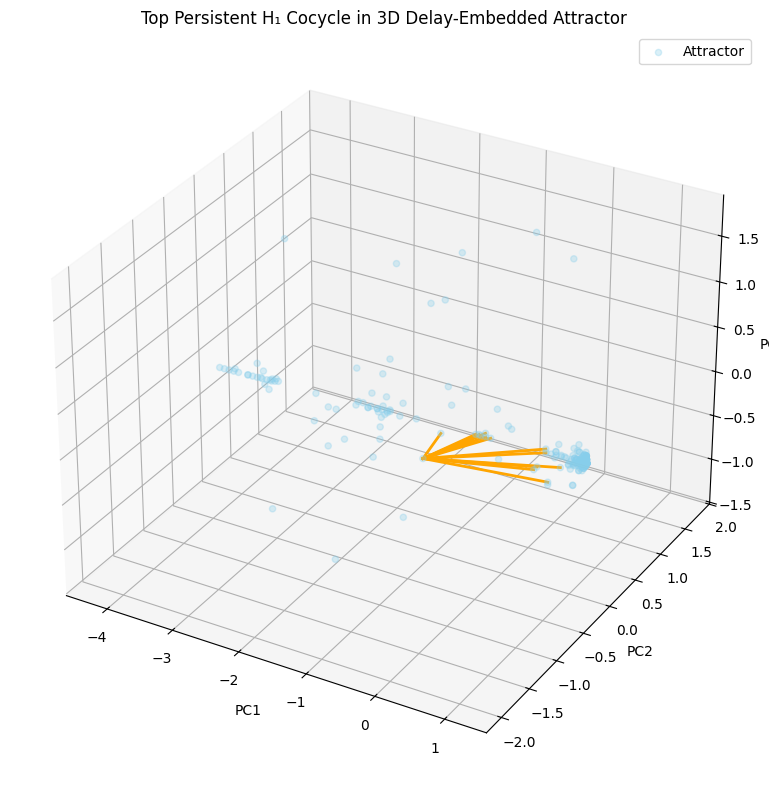

In [51]:
import numpy as np
from ripser import ripser
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# -----------------------------------------------------
# STEP 1: Delay Embed (assuming you already have this)
# embedded = delay_embed(ridge_scaled, tau=5, m=3)
# Or substitute your existing delay-embedded point cloud:
# embedded.shape == (n_points, 3)

# -----------------------------------------------------
# STEP 2: Compute Persistent Homology + Cocycles
result = ripser(embedded, maxdim=1, coeff=2, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']

# -----------------------------------------------------
# STEP 3: Extract the most persistent H1 cocycle
h1 = diagrams[1]
lifetimes = h1[:, 1] - h1[:, 0]
top_index = lifetimes.argmax()
top_cocycle = cocycles[1][top_index]

# -----------------------------------------------------
# STEP 4: Project to 3D with PCA
pca = PCA(n_components=3)
projected_3d = pca.fit_transform(embedded)

# -----------------------------------------------------
# STEP 5: Plot the attractor and top cocycle edges
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Attractor
ax.scatter(projected_3d[:, 0], projected_3d[:, 1], projected_3d[:, 2],
           alpha=0.3, label='Attractor', color='skyblue')

# Top cocycle edges (plot top N strongest)
sorted_edges = sorted(top_cocycle, key=lambda x: abs(x[2]), reverse=True)
N = 20

for i, (a, b, coeff) in enumerate(sorted_edges[:N]):
    x = [projected_3d[a, 0], projected_3d[b, 0]]
    y = [projected_3d[a, 1], projected_3d[b, 1]]
    z = [projected_3d[a, 2], projected_3d[b, 2]]
    ax.plot(x, y, z, color='orange', linewidth=2)

ax.set_title("Top Persistent H₁ Cocycle in 3D Delay-Embedded Attractor")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
window_size = 150
step = 10
max_lifetimes = []

for start in range(0, len(ridge) - window_size, step):
    window = ridge[start:start + window_size]
    scaled = StandardScaler().fit_transform(window.reshape(-1, 1)).flatten()
    embedded = delay_embed(scaled, tau=5, m=3)
    
    dgm = ripser(embedded, maxdim=1)['dgms'][1]
    if len(dgm) > 0:
        lifetimes = dgm[:, 1] - dgm[:, 0]
        max_lifetimes.append(np.max(lifetimes))
    else:
        max_lifetimes.append(0)


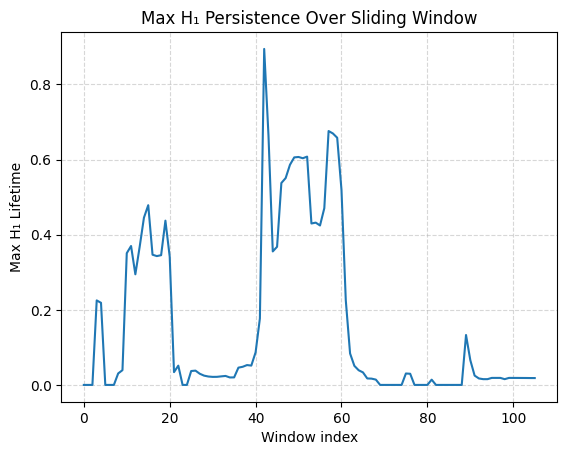

In [53]:
plt.plot(max_lifetimes)
plt.title("Max H₁ Persistence Over Sliding Window")
plt.xlabel("Window index")
plt.ylabel("Max H₁ Lifetime")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [54]:
# Average entropy per TDA window
entropy_windowed = [
    np.mean(real_e[i:i+window_size])
    for i in range(0, len(real_e) - window_size, step)
]


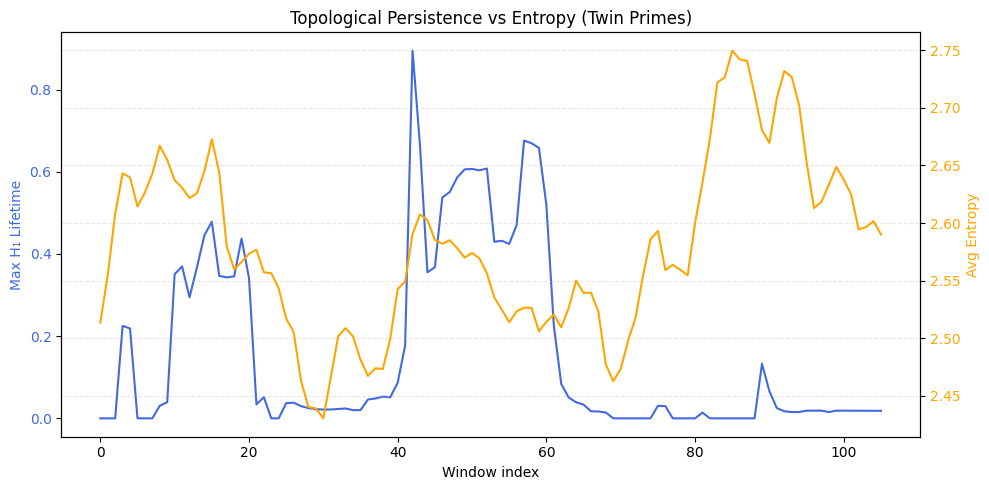

In [55]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Max H₁ on left axis
ax1.plot(max_lifetimes, color='royalblue', label='Max H₁ Lifetime')
ax1.set_xlabel("Window index")
ax1.set_ylabel("Max H₁ Lifetime", color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# Entropy on right axis
ax2 = ax1.twinx()
ax2.plot(entropy_windowed, color='orange', label='Entropy (mean per window)')
ax2.set_ylabel("Avg Entropy", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title("Topological Persistence vs Entropy (Twin Primes)")
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [56]:
from scipy.stats import pearsonr

r, p = pearsonr(entropy_windowed, max_lifetimes)
print(f"Pearson correlation: r = {r:.3f}, p = {p:.3g}")


Pearson correlation: r = -0.057, p = 0.564


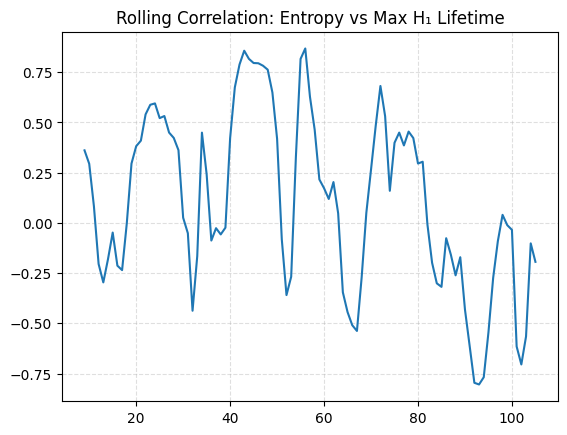

In [57]:
import pandas as pd

rolling_corr = pd.Series(entropy_windowed).rolling(10).corr(pd.Series(max_lifetimes))
plt.plot(rolling_corr)
plt.title("Rolling Correlation: Entropy vs Max H₁ Lifetime")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [58]:
# Parameters
window_size = 150
step = 10
target_window = 45

start = target_window * step
end = start + window_size

entropy_slice = real_e[start:end]


In [59]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaled = StandardScaler().fit_transform(np.array(entropy_slice).reshape(-1, 1)).flatten()
embedded = delay_embed(scaled, tau=5, m=3)


In [60]:
from ripser import ripser

result = ripser(embedded, maxdim=1, coeff=2, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']

# Top cocycle
h1 = diagrams[1]
lifetimes = h1[:, 1] - h1[:, 0]
top_idx = lifetimes.argmax()
top_cocycle = cocycles[1][top_idx]


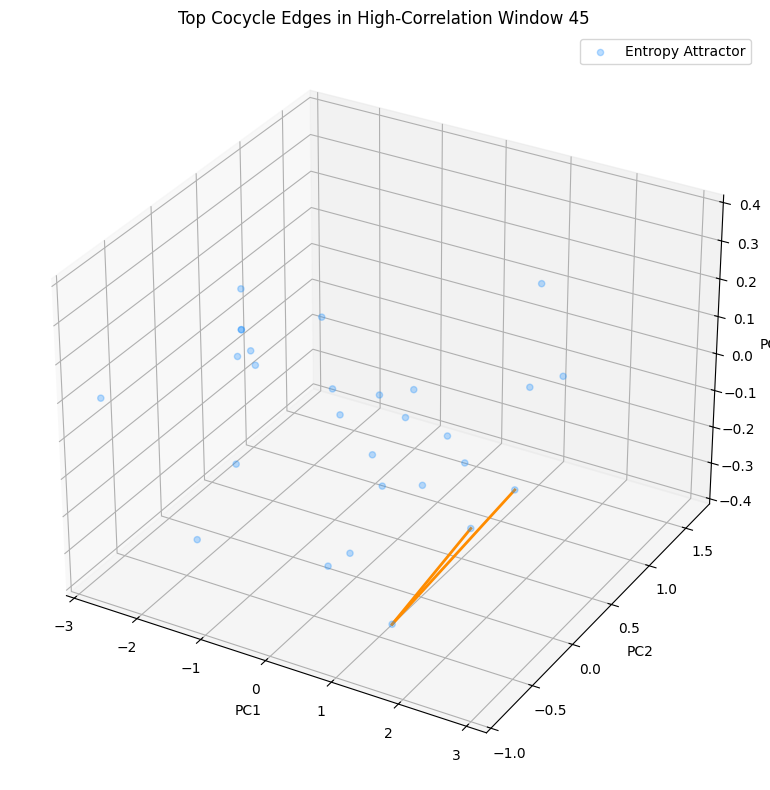

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D PCA
pca = PCA(n_components=3)
projected = pca.fit_transform(embedded)

# Sort cocycle edges by |coeff|
sorted_edges = sorted(top_cocycle, key=lambda x: abs(x[2]), reverse=True)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2],
           alpha=0.3, label='Entropy Attractor', color='dodgerblue')

# Overlay top edges
for a, b, coeff in sorted_edges[:20]:
    x = [projected[a, 0], projected[b, 0]]
    y = [projected[a, 1], projected[b, 1]]
    z = [projected[a, 2], projected[b, 2]]
    ax.plot(x, y, z, color='darkorange', linewidth=2)

ax.set_title(f"Top Cocycle Edges in High-Correlation Window {target_window}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend()
plt.tight_layout()
plt.show()


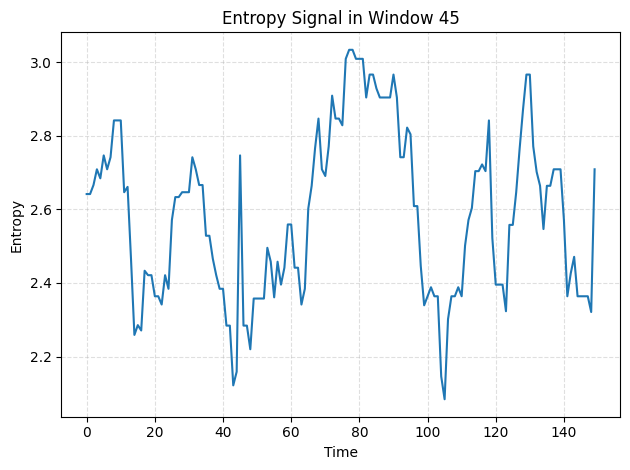

In [62]:
plt.plot(entropy_slice)
plt.title(f"Entropy Signal in Window {target_window}")
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [63]:
threshold = 0.3
event_indices = [i for i, h1 in enumerate(max_lifetimes) if h1 > threshold]

print(f"Topological events detected at windows: {event_indices}")


Topological events detected at windows: [10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


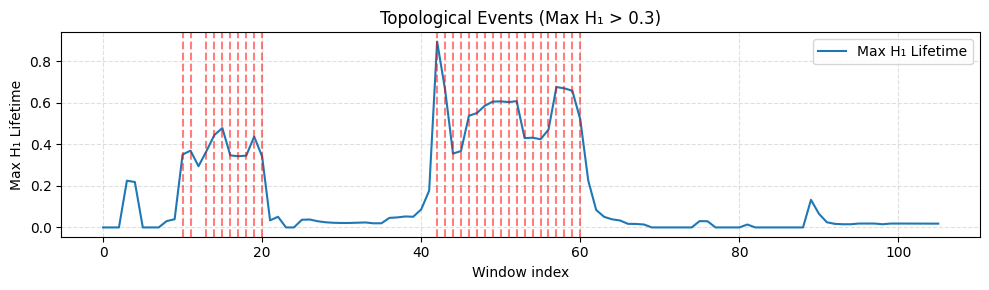

In [64]:
plt.figure(figsize=(10, 3))
plt.plot(max_lifetimes, label="Max H₁ Lifetime")
for idx in event_indices:
    plt.axvline(idx, color='red', linestyle='--', alpha=0.5)

plt.title("Topological Events (Max H₁ > 0.3)")
plt.xlabel("Window index")
plt.ylabel("Max H₁ Lifetime")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
from ripser import ripser
from scipy.stats import pearsonr

np.random.seed(42)
shuffled_entropy = np.random.permutation(real_e)

shuffled_lifetimes = []

for start in range(0, len(shuffled_entropy) - window_size, step):
    window = shuffled_entropy[start:start + window_size]
    scaled = StandardScaler().fit_transform(np.array(window).reshape(-1, 1)).flatten()
    embedded = delay_embed(scaled, tau=5, m=3)
    
    dgm = ripser(embedded, maxdim=1)['dgms'][1]
    if len(dgm) > 0:
        lifetimes = dgm[:, 1] - dgm[:, 0]
        shuffled_lifetimes.append(np.max(lifetimes))
    else:
        shuffled_lifetimes.append(0)


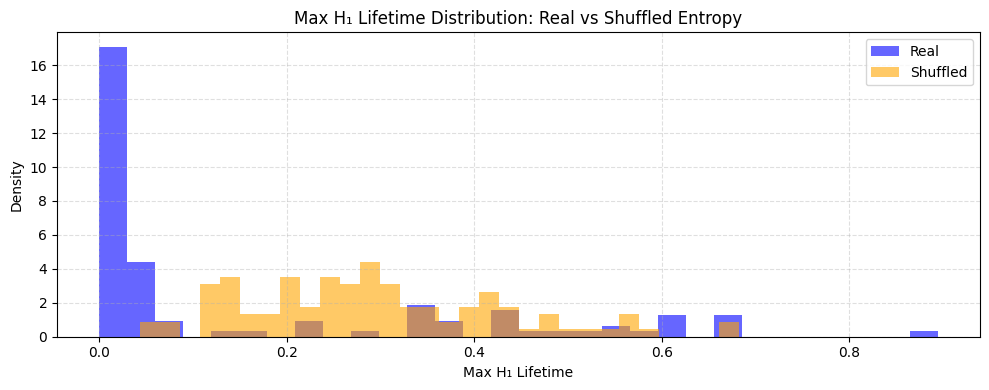

In [66]:
plt.figure(figsize=(10, 4))
plt.hist(max_lifetimes, bins=30, alpha=0.6, label="Real", color='blue', density=True)
plt.hist(shuffled_lifetimes, bins=30, alpha=0.6, label="Shuffled", color='orange', density=True)
plt.title("Max H₁ Lifetime Distribution: Real vs Shuffled Entropy")
plt.xlabel("Max H₁ Lifetime")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [67]:
from scipy.stats import ks_2samp

stat, pval = ks_2samp(max_lifetimes, shuffled_lifetimes)
print(f"KS Test: D = {stat:.3f}, p = {pval:.3g}")


KS Test: D = 0.632, p = 3.49e-20


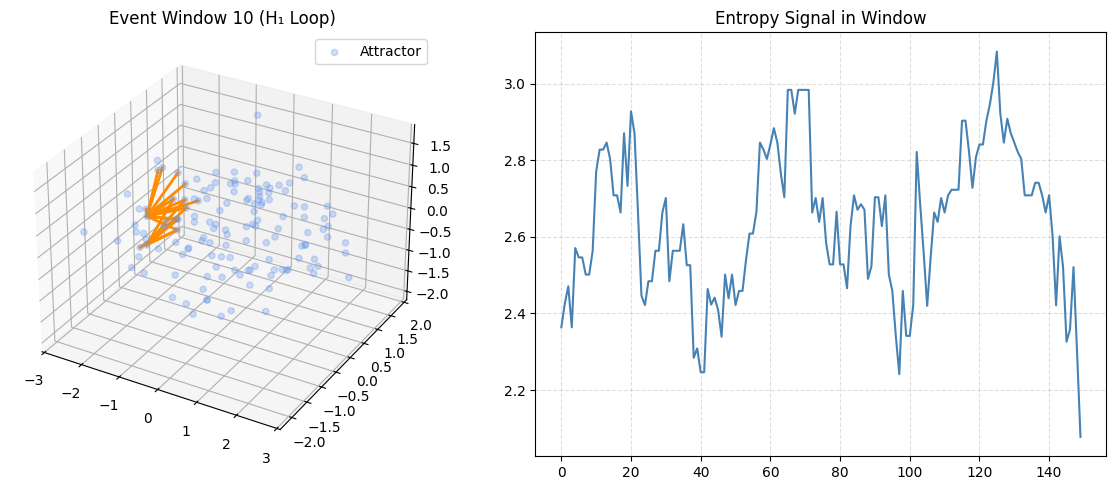

interactive(children=(IntSlider(value=0, description='Event', max=6), Output()), _dom_classes=('widget-interac…

<function __main__.plot_event(window_index)>

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ripser import ripser
import ipywidgets as widgets
from IPython.display import display

# Your real data here:
# - entropy_signal: your original entropy array
# - event_indices: list of window indices where max H1 > threshold
# - window_size, step: your sliding window params
entropy_signal = real_e  # or gap_entropy
event_indices = [10, 13, 15, 44, 47, 50, 58]  # use your detected topological windows
window_size = 150
step = 10

def delay_embed(data, tau=5, m=3):
    n_points = len(data) - (m - 1) * tau
    return np.array([data[i:i + m * tau:tau] for i in range(n_points)])

def plot_event(window_index):
    idx = event_indices[window_index]
    start = idx * step
    end = start + window_size
    signal = np.array(entropy_signal[start:end])

    # Embed + scale
    scaled = StandardScaler().fit_transform(signal.reshape(-1, 1)).flatten()
    embedded = delay_embed(scaled, tau=5, m=3)

    # Run ripser
    result = ripser(embedded, maxdim=1, do_cocycles=True)
    h1 = result['dgms'][1]
    cocycles = result['cocycles'][1]

    if len(h1) == 0:
        print("No H₁ features detected.")
        return

    lifetimes = h1[:, 1] - h1[:, 0]
    top_idx = np.argmax(lifetimes)
    top_cocycle = cocycles[top_idx]

    # Project to 3D
    projected = PCA(n_components=3).fit_transform(embedded)

    # Plot
    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(*projected.T, alpha=0.3, color='cornflowerblue', label='Attractor')
    for a, b, coeff in sorted(top_cocycle, key=lambda x: abs(x[2]), reverse=True)[:20]:
        ax.plot(*zip(projected[a], projected[b]), color='darkorange', lw=2)
    ax.set_title(f"Event Window {idx} (H₁ Loop)")
    ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(signal, color='steelblue')
    ax2.set_title("Entropy Signal in Window")
    ax2.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

# Create widget
slider = widgets.IntSlider(min=0, max=len(event_indices) - 1, step=1, description="Event")
widgets.interact(plot_event, window_index=slider)
